# Best Gaussian process regression model selection through cross validation - GPy <br>
Reference : <br>
https://datachemeng.com/kernel_design_in_gpr/ <br>
https://upura.hatenablog.com/entry/2018/12/04/224436

### Import library and dataset

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel, WhiteKernel

# Cross validation
from sklearn.model_selection import (KFold, ShuffleSplit)
from sklearn.metrics import mean_squared_error, r2_score

#GPy
import GPy, GPyOpt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
print(X.shape)
X.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
print(y.shape)
y.head()

(214, 1)


,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
X_ = X.copy()
y_ = y.copy()

In [8]:
n_features = len(X.columns)
n_features

8

In [9]:
# dictionary of kernel
dim_num = n_features
kernel_dict = {0:GPy.kern.RBF(input_dim = dim_num),
               1:GPy.kern.RBF(input_dim = dim_num) + GPy.kern.Bias(input_dim = dim_num),
               2:GPy.kern.Bias(input_dim = dim_num) * GPy.kern.Matern52(input_dim = dim_num) + GPy.kern.White(input_dim = dim_num),
               3:GPy.kern.RBF(input_dim = dim_num) + GPy.kern.Bias(input_dim = dim_num) + GPy.kern.Linear(input_dim = dim_num),
               4:GPy.kern.Matern32(input_dim = dim_num) * GPy.kern.RBF(input_dim = dim_num),
               5:GPy.kern.Matern52(input_dim = dim_num) * GPy.kern.RBF(input_dim = dim_num),
               6:GPy.kern.Exponential(input_dim = dim_num),
               7:GPy.kern.Exponential(input_dim = dim_num) * GPy.kern.RBF(input_dim = dim_num) + GPy.kern.White(input_dim = dim_num)}

### List of scores by KFold and Shaffle split

In [10]:
score_mean_KF = list()
score_mean_SS = list()

In [11]:
split_num = 5

In [12]:
def MakeModel(X, y, kern):
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    model = GPy.models.GPRegression(X, y, kernel = kern)
    model.optimize()
    
    return model

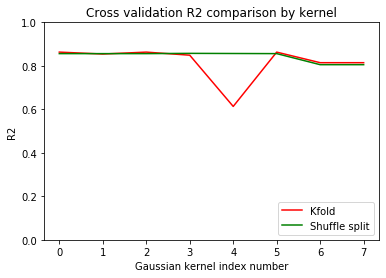

In [13]:
with np.errstate(invalid='ignore'):
    for i in kernel_dict.keys() :
        kern = kernel_dict[i]
        cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)
        score_temp_KF = list()
        for train_index, test_index in cv_KF.split(X):
            X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
        
            model_temp = MakeModel(X_train, y_train, kern)

            y_pred = model_temp.predict(np.array(X_test))[0]
            r2 = r2_score(y_test, y_pred)

            score_temp_KF.append(r2)
        score_mean_KF.append(np.mean(score_temp_KF))
        
    for i in kernel_dict.keys() :
        kern = kernel_dict[i]
        cv_SS = ShuffleSplit(n_splits = split_num, random_state = 0, test_size=0.2, train_size=None)
        score_temp_SS = list()
        for train_index, test_index in cv_SS.split(X):
            X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
        
            model_temp = MakeModel(X_train, y_train, kern)

            y_pred = model_temp.predict(np.array(X_test))[0]
            r2 = r2_score(y_test, y_pred)

            score_temp_SS.append(r2)
        score_mean_SS.append(np.mean(score_temp_SS))

plt.plot(score_mean_KF, c = 'r', label = 'Kfold')
plt.plot(score_mean_SS, c = 'g', label = 'Shuffle split')
plt.title('Cross validation R2 comparison by kernel')
plt.xlabel('Gaussian kernel index number')
plt.ylabel('R2'), plt.ylim(0.0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

In [14]:
print('kernel index', 'KFold R2', 'ShuffleSplit R2', sep = '\t')
for i in kernel_dict.keys():
    print(i, '', ' {:.4}'.format(score_mean_KF[i]), '', ' {:.4}'.format(score_mean_SS[i]), sep = '\t')

kernel index	KFold R2	ShuffleSplit R2
0		 0.8632		 0.8562
1		 0.8544		 0.8562
2		 0.8631		 0.8562
3		 0.849		 0.8574
4		 0.6134		 0.8568
5		 0.8631		 0.8562
6		 0.8145		 0.8054
7		 0.8145		 0.8054


### Best model selection

In [15]:
best_kernel_index = score_mean_SS.index(np.max(score_mean_SS))
print('Best kernel index (highest R2) = ', best_kernel_index)

Best kernel index (highest R2) =  3


In [16]:
best_gaussr = MakeModel(X, y, kernel_dict[best_kernel_index])

In [17]:
# Save the best model
import pickle
with open('best_gaussr_GPy.pickle', mode='wb') as f:
    pickle.dump(best_gaussr, f)

### Recall the model

In [18]:
with open('best_gaussr_GPy.pickle', mode='rb') as f:
    best_gaussr_recall = pickle.load(f)

In [19]:
y = best_gaussr_recall.predict(np.array(X_test))[0]
y[:5]

array([[1.5182552 ],
       [1.5170376 ],
       [1.51372955],
       [1.52411883],
       [1.51931176]])

R2 =   0.9427


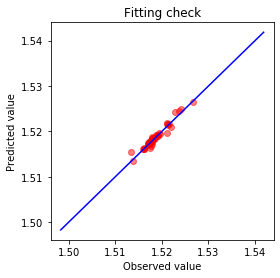

In [20]:
# For all
print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [21]:
y_.shape

(214, 1)

In [22]:
# By validation set
print('Check best kernel perfromance in folds')
for train_index, test_index in cv_KF.split(X_):
    X_train, X_test, y_train, y_test = X_.loc[train_index], X_.loc[test_index], y_.loc[train_index], y_.loc[test_index]
    
    X_train = np.array(X_train)
    X_test  = np.array(X_test)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test  = np.array(y_test).reshape(-1, 1)
    
    y_pred = best_gaussr_recall.predict(X_test)
    R2_gauss = r2_score(y_test, y_pred[0])
    print(' {:.4}'.format(R2_gauss))

Check best kernel perfromance in folds
 0.9533
 0.9107
 0.7851
 0.8593
 0.8905


### Kernels provided in GPy

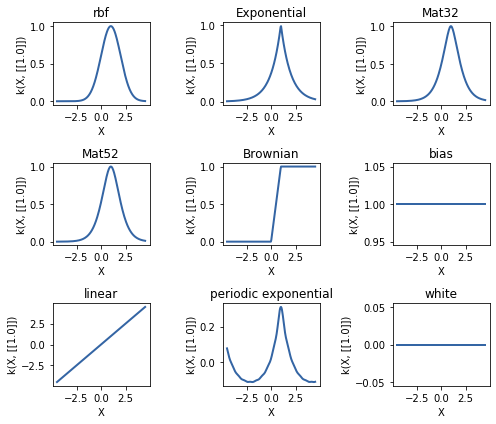

In [23]:
figure, axes = plt.subplots(3,3, figsize=(7,6), tight_layout=True)
kerns = [GPy.kern.RBF(1),
         GPy.kern.Exponential(1),
         GPy.kern.Matern32(1),
         GPy.kern.Matern52(1),
         GPy.kern.Brownian(1),
         GPy.kern.Bias(1),
         GPy.kern.Linear(1),
         GPy.kern.PeriodicExponential(1),
         GPy.kern.White(1)]
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=1)
    a.set_title(k.name.replace('_', ' '))